# Temperature Profile Classification - 2 Class system - r3
GMM classification of Southern Ocean Argo float temperature profile data. This notebook looks at automatic generation for PCA N values, with 2 classes.<br><br>
### Dask import

<br>

### Choices for data

In [1]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceId = 'UKESM1-0-LL'
dataInstitutionId = 'MOHC'
approvedIds = ["r3i1p1f2"] #insert start of approved member_ids

#File imports
maskName = "OceanMaskVolcello"
modelName = "GMM_UK_2Class_R3_v2"

#Data definitions
startDate = '1980-01'
endDate = '2009-12'
timeRange = slice(startDate, endDate)
levSel = slice(0, 2000) #Selected levels to be investigated
maxLat = -30 #Selected latitude to be investigated
runIdSel = 0

#Custom GMM variables
saveModel = True #if true saves a model under model name. To work createModel has to be enabled.
pcaThreshold = 0.98
pcaNControl = 0 #set to int value to select, if set to 0 pcaThreshold is used to automatically assign value 
firstBicLoopControl = 10 #number of times bic value is calculated for each number of classes
cvType = "full"

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [2]:
#Import cell
import calendar
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import matplotlib as mpl ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import config
from dask import delayed
from joblib import dump, load
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing

config.set(**{'array.slicing.split_large_chunks': True})
print("Imports complete")

Imports complete


<br>

### Importing data sets
Importing the data for the models.

<b>Import sample data set and corresponding time/geo data</b>

In [3]:
#Importing UK ESM data cell

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceId) & df.institution_id.eq(dataInstitutionId)]

memberArr = np.empty(shape=(0), dtype=bool)
for i in dfFilt["member_id"]:
    rowSel = i[:] in approvedIds #adapt i[:] to match size of approvedIds
    memberArr = np.append(memberArr, rowSel)

memberSer = pd.Series(memberArr, name='bools')
dfFilt = dfFilt[memberSer.values]

fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" "+dataSourceId+" data sets opened")
else:
    print("No UKESM data sets opened")
    
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunId') #Combining data sets

dataRaw = fileSet.thetao

try:
    dataRaw = dataRaw.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

print("Data sets successfully merged and renamed into dataRaw.")

1 UKESM1-0-LL data sets opened
Data sets successfully merged and renamed into dataRaw.


In [4]:
dfFilt

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
213868,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,Omon,thetao,gn,gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/histori...,NaN,20190708


In [5]:
#UK ESM raw processing cell
dfESMLev = dataRaw.sel(lev=levSel) #Selects level data down to 2k
dfESMLevT = dfESMLev.sel(time=timeRange)
dfESMLatLevT = dfESMLevT.where(dfESMLevT.lat < maxLat, drop=True) #Selection of latitude
dfESMLatLevT = dfESMLatLevT.squeeze()

globalStartDate = dfESMLatLevT["time"][0].values
globalDateInc = dfESMLatLevT["time"][1].values - globalStartDate
globalEndDateIn = dfESMLatLevT["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("UKESM data loaded and stored in dfESMLatLevT")

UKESM data loaded and stored in dfESMLatLevT


<br>
<b>Loading ocean Masks</b>

In [6]:
#Ocean mask import cell
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
maskFile = xr.open_dataset("OceanMaskUKESM1")
oceanMask2 = maskFile.to_array()
print("Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).")

Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).


<br>
<b>Unpacking ocean masks</b>

In [7]:
#Mask unpacking cell
geoRange = oceanMask #copying mask
geoRange = geoRange.rename({"variable":"cleanMe"}) #Dimension removal
geoRange = geoRange.sel(cleanMe = geoRange.cleanMe.values[0]) #Dimension removal
geoRange = geoRange.reset_coords("cleanMe", drop=True) #Dimension removal
geoRangeS = geoRange.stack(ij =("i", "j")) #Stacking
geoRangeFilt = geoRangeS.dropna("ij")
print("Ocean mask unpacked into geoRangeFilt.")

geoRange2 = oceanMask2 #copying mask
geoRange2S = geoRange2.stack(ij =("i", "j")) #Stacking
geoRangeFilt2 = geoRange2S.dropna("ij")
print("UKESM Ocean mask unpacked into geoRangeFilt2.")

Ocean mask unpacked into geoRangeFilt.
UKESM Ocean mask unpacked into geoRangeFilt2.


<br>
<b>Date Calculations</b>

In [8]:
#Date calculation cell
startDateNp = np.datetime64(startDate, 'M')
endDateNp = np.datetime64(endDate, 'M')

timeDiff = endDateNp - startDateNp
timeDiff = timeDiff.astype(int) + 1
print("Calculated date range.")

Calculated date range.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
<li>pickRand - Takes in data frame and returns sampled data frame with a randomly selected number of rows from the input data frame, controled by the second input variable to the function.
<li>storeMeta - Returns a np array containing the latitude and longitude data for an input xarray and associated ij.
<li>loadModel - loadeds and returns GMM model named in input.
<li>saveModel - saves input GMM model to provided name, if no name provided default is GMMGenerated.
</ul>

In [9]:
#Calculation functions cell
def pickRand(dataArray, sampleFactor):
    '''Returns a sample of the input array, size of sampled array is based on sampleFactor. For factor > 1 that many points are chosen, for factor < 1 that % is taken of the array'''
    arrLen = len(dataArray)
    if sampleFactor > 1:
        sampleSize = int(sampleFactor)
    elif sampleFactor > 0:
        sampleSize = int(sampleFactor*arrLen)
    else:
        return 1
    
    filtArr = np.zeros(arrLen, dtype=bool) # empty mask
    sampleId = np.random.choice(arrLen, sampleSize, False) # np array of randomly generated non repeating numbers
    for i in sampleId:
        filtArr[i] = True # populating mask
    return dataArray[filtArr] # applies mask

def pickRandMask(maskLen, maskQuantity, sampleFactor):
    '''Returns a linear mask for the input dimensions, size of mask is based on sampleFactor. For factor > 1 that many points are chosen, for factor < 1 that % is taken of the array'''
    if sampleFactor > 1:
        sampleSize = int(sampleFactor)
    elif sampleFactor > 0:
        sampleSize = int(sampleFactor*maskLen)
    else:
        return 1
    
    globalArr = np.empty(shape=(0), dtype=bool)
    for i in range(maskQuantity):
        filtArr = np.zeros(maskLen, dtype=bool) # empty mask
        sampleId = np.random.choice(maskLen, sampleSize, False) # np array of randomly generated non repeating numbers
        for j in sampleId:
            filtArr[j] = True # populating mask
        globalArr = np.append(globalArr, filtArr)
    return globalArr


def storeMeta(dataArray):
    '''Returns a np array containing the latitude and longitude data for the input xarray and the associated ij index'''
    storeLen = len(dataArray["lat"]) # assumes each lat has a corresponding lon
    storage = np.empty(shape=(0,storeLen))
    storage = np.append(storage, [dataArray["lat"].values], axis = 0)
    storage = np.append(storage, [dataArray["lon"].values], axis = 0)
    #storage = np.append(storage, [dataArray["time"].values], axis = 0)
    #storage = np.append(storage, [dataArray["ij"].values], axis = 0)
    return storage


def loadModel(modelName:str):
    '''Loades the input GMM model named in the functions input. Returns loaded model.'''
    means = np.load(modelName + '_means.npy')
    covar = np.load(modelName + '_covariances.npy')
    GMModel = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    GMModel.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    GMModel.weights_ = np.load(modelName + '_weights.npy')
    GMModel.means_ = means
    GMModel.covariances_ = covar
    return GMModel


def saveModel(GMModel, modelName = "GMMGenerated"):
    '''Saves the input GMM model's weights, means and covariances. Assigns input name if provided to model.'''
    GMModel_name = str(modelName)
    np.save(modelName + '_weights', GMModel.weights_, allow_pickle=False)
    np.save(modelName + '_means', GMModel.means_, allow_pickle=False)
    np.save(modelName + '_covariances', GMModel.covariances_, allow_pickle=False)
    return 0

print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
<li> bicPlot - Plots BIC score array against component number.
<li> locationPlotGroup - plots location and classification of data points for an input numpy array.
<li> locationPlotGroupDF - plots location and classification of data points for an input data frame.
<li> locationPlotGroupDFMonthly - plots location and classification of data points for an input data frame in monthly subplots.
<li> locationPlotTime - plots locations of an input data array on a map with a colour scale for time.
<li> locationPlotUncertaintyDF - plots uncertainty in classification on a location plot.
<li> tempPointPlot - Plots the temperature profile of a single point against depth.
<li> tempGroupPlot - Plots the mean/+-1std temperature profiles of all classes in input dataArrays (seperate mean and std).
</ul>

In [10]:
#Plotting functions Cell
sampleDepthAxis = dfESMLatLevT["lev"]

def bicPlot(bicArray, startNo, endNo, skipNo, title, label, plotNo):
    '''Plots input BIC score array'''
    plt.figure(plotNo, figsize=(20, 8))
    plt.style.use("seaborn-darkgrid")
    componentRange = range(startNo, endNo, skipNo)
    plt.plot(componentRange, bicArray, label = str(label))
    
    bicArrayMax = np.max(bicArray)
    bicArrayMin = np.min(bicArray)
    bicRange = bicArrayMax-bicArrayMin
    if bicRange == 0:
        bicRange = 20 #provides border 1 if all bic values are identical
    plt.xticks(componentRange)
    plt.xlim([startNo-0.5, endNo+0.5])
    plt.ylim([bicArrayMin-0.05*bicRange, bicArrayMax+0.05*bicRange])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Number of components")
    plt.ylabel("BIC score")
    plt.title(title)


def locationPlotGroup(metaDataArray, size, plotNo):
    '''Plots locations of numpy arrays with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(metaDataArray[1], metaDataArray[0], transform=ccrs.PlateCarree(), c =  metaDataArray[3], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Grouped Sample Locations ("+str(len(metaDataArray[0]))+")")


def locationPlotGroupDFTime(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  mdates.date2num(dataFrame["time"]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))
    
    
def locationPlotGroupDFLab(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["labelSorted"], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotGroupDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["labelSorted"], cmap='RdBu_r')
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")


def locationPlotTime(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")


def locationPlotUncertaintyDF(dataFrame, title, size, plotNo):
    '''Plots input data array classification uncertainties'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["classUncertainty"], cmap='Blues')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotUncertaintyDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["classUncertainty"], cmap='Blues', vmin=0, vmax=1)
        #cb = plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")


def locationPlotXr(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray["lon"], dataArray["lat"], transform=ccrs.PlateCarree())
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray["lat"]))+")")        


def tempPointPlot(dataArray, label, title, plotNo):
    '''Displays temperature profile plot for a given data set, singular point'''
    plt.figure(plotNo)
    plt.plot(dataArray, sampleDepthAxis, label = label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(str(title))
    plt.gca().invert_yaxis()


def tempGroupProfile(dataArrayMean, dataArrayStd, plotNo):
    '''Displays mean /+-1 std temperature profiles for classes in dataArrayMean and dataArrayStd. Requires sampleDepthAxis'''
    dataCompNo = len(dataArrayMean)   
    columnNames = sampleDFSortMeans.columns.values
    dataStart = np.where(columnNames == sampleDepthAxis[0].values)[0][0]
    subPlotX = int(np.ceil(dataCompNo/5))
    
    plt.figure(plotNo, figsize=(35, 10*subPlotX))
    plt.style.use("seaborn-darkgrid")
    palette = cm.coolwarm(np.linspace(0,1, dataCompNo))
    
    for i in range(dataCompNo):
        meanT = dataArrayMean.iloc[i, dataStart:].to_numpy()
        stdT = dataArrayStd.iloc[i, dataStart:].to_numpy()
        
        plt.subplot(subPlotX, 5, i+1)
        plt.plot(meanT, sampleDepthAxis, marker='', linestyle="solid", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT+stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT-stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        
        plt.xlim([-2,20])
        plt.ylim([0,1000])
        ax = plt.gca()
        ax.invert_yaxis()
        ax.grid(True)
        
        fs = 16 #font size
        plt.xlabel("Temperature (°C)", fontsize=fs)
        plt.ylabel("Depth (m)", fontsize=fs)
        plt.title("Class = "+str(i), fontsize=fs)
        mpl.rc("xtick", labelsize=fs)
        mpl.rc("ytick", labelsize=fs)
        
        '''
        textstr = '\n'.join((
            r'N profs. = %i' % (nprofs[nrow], ),
            r'Mean lon = %i' % (meanLon, ),
            r'Mean lat = %i' % (meanLat, ),
            r'Post. = %i' % (meanMaxPP, )))
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
        ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs, verticalalignment='top', bbox=props)
        '''


print("Plotting functions defined.")

Plotting functions defined.


<br>

### Plotting Ocean Mask

In [11]:
#Mask plotting cell
#locationPlotXr(geoRangeFilt, (10,10), 1)
#locationPlotXr(geoRangeFilt2, (10,10), 2)
plt.show()

<br>

### Generating Data Samples

In [12]:
#Identifying, masking and stacking raw data cell
dfESMLatLevTStack = dfESMLatLevT.stack(ij =("i", "j"))
dfESMLatLevTStack = dfESMLatLevTStack.transpose('time', 'ij', 'lev')
dfESMLatLevTStackFilt = dfESMLatLevTStack.sel(ij = geoRangeFilt.ij.values) #Produces 22194
print("Raw data identified, stacked and stored in dfESMLatLevTStackFilt. Data dimensions: "+str(dfESMLatLevTStackFilt.sizes)+".")

Raw data identified, stacked and stored in dfESMLatLevTStackFilt. Data dimensions: Frozen({'time': 360, 'ij': 22194, 'lev': 54}).


In [13]:
#Sample mask import cell
importName = modelName[:-4] + "1_Mask.npy"
mask = np.load(importName)
print("Data mask loaded from "+ importName +".")

Data mask loaded from GMM_UK_2Class_R1_Mask.npy.


In [14]:
#Sample selection cell
sampleDataRaw = dfESMLatLevTStackFilt.reset_index('ij')
sampleDataRaw = sampleDataRaw.stack(ijT = ('time', 'ij'))
sampleData = sampleDataRaw[:,mask]
sampleData = sampleData.transpose('ijT', 'lev')
print("Sample data calculated and stored in sampleData. Sample data dimensions: "+str(sampleData.sizes)+".")

Sample data calculated and stored in sampleData. Sample data dimensions: Frozen({'ijT': 2716200, 'lev': 54}).


<br>

### Placing sample data into tables

In [15]:
#Location and time data to table cell
metaData = {"lat":sampleData["lat"], "lon":sampleData["lon"], "time":sampleData["time"]}
sampleMetaDF = pd.DataFrame(metaData, columns=["lat", "lon", "time"])
print("Sample lat, lon and time converted to datafile (sampleMetaDF). "+str(len(sampleMetaDF))+" samples identified.")
sampleMetaDF.head()

Sample lat, lon and time converted to datafile (sampleMetaDF). 2716200 samples identified.


,lat,lon,time
0,-65.703316,73.5,1980-01-01
1,-65.288567,73.5,1980-01-01
2,-63.562469,73.5,1980-01-01
3,-60.270821,73.5,1980-01-01
4,-59.771149,73.5,1980-01-01


In [16]:
#Temperature data to table and table merging cell
#Generating surface temperature level value and column name
surfaceTemp = sampleData["lev"][0].values
surfaceData = sampleData.sel(lev = surfaceTemp)
surfaceTempName = "Surface Temp ("+str(np.round(surfaceTemp,2))+")"

#Exporting sample data into pandas
if True:
    sampleDataDF = sampleData.to_pandas()
    
    sampleDataDFClean = sampleDataDF.reset_index()
    sampleDataDFClean = sampleDataDFClean.drop(columns=['ij'])
    sampleDF = pd.concat([sampleMetaDF, sampleDataDFClean.drop(columns=["time"])], axis=1) #Removes time from second table for merge
else:
    sampleDF = sampleMetaDF
    
sampleDF["time"] = pd.to_datetime(sampleDF["time"])
print("SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF. "+str(len(sampleDF))+" samples identified.")
sampleDF.head()

SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF. 2716200 samples identified.


,lat,lon,time,0.5057600140571594,1.5558552742004395,2.6676816940307617,3.8562798500061035,5.140361309051514,6.543033599853516,8.09251880645752,...,856.678955078125,947.4478759765625,1045.854248046875,1151.9912109375,1265.8614501953125,1387.376953125,1516.3636474609375,1652.5684814453125,1795.6707763671875,1945.2955322265625
0,-65.703316,73.5,1980-01-01,-1.270198,-1.278426,-1.298570,-1.315566,-1.330114,-1.344970,-1.361599,...,0.826923,0.787950,0.732231,0.670286,0.608106,0.545688,0.491127,0.438452,0.378714,0.319977
1,-65.288567,73.5,1980-01-01,-1.215177,-1.222939,-1.236639,-1.251741,-1.265477,-1.279213,-1.294460,...,0.826653,0.782907,0.729958,0.672249,0.608251,0.545634,0.488621,0.432889,0.369259,0.311733
2,-63.562469,73.5,1980-01-01,-0.623297,-0.655731,-0.686510,-0.712406,-0.737661,-0.764478,-0.794132,...,1.073619,1.012067,0.949024,0.882289,0.809235,0.728964,0.643517,0.556008,0.467829,0.382068
3,-60.270821,73.5,1980-01-01,-0.119660,-0.139341,-0.165811,-0.191353,-0.216995,-0.243212,-0.273204,...,1.675978,1.567269,1.450658,1.328806,1.202450,1.072643,0.943726,0.820530,0.705919,0.608210
4,-59.771149,73.5,1980-01-01,0.118221,0.096480,0.064821,0.033657,0.004099,-0.027825,-0.066302,...,1.589191,1.490842,1.384766,1.272758,1.153625,1.027860,0.903003,0.792074,0.691611,0.619673


In [17]:
#Location Plotting Cell
#locationPlotGroupDFTime(sampleDF, "Sample locations", (10,10), 1) #Should match mask
plt.show()

### Scaling
<b>Scaling Implementation</b><br>
Applying scaling to the data set, ensuring all levels have same influence over data.

In [18]:
#Scaler calculation cell
scalerUK = preprocessing.StandardScaler().fit(sampleData)
print("Scaler calculated for data, stored in scalerUK.")

Scaler calculated for data, stored in scalerUK.


In [19]:
#Scaler application cell
sampleDataScaled = scalerUK.transform(sampleData)
print("Sample data scaled and stored in sampleDataScaled.")

Sample data scaled and stored in sampleDataScaled.


<br>
<b>Scaling comparison</b><br>
Comparing raw temperature profiles with their scaled equivalent. To show individual plots set solo to True.

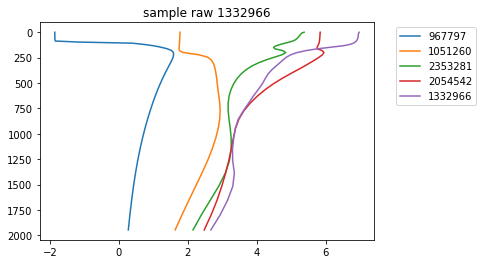

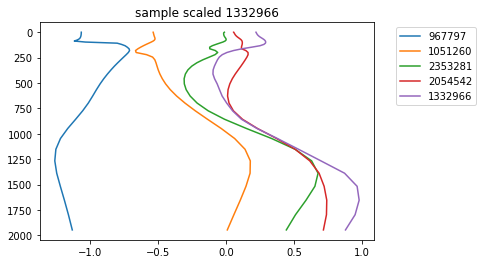

In [20]:
#Scaled temperature profile plotting cell
solo = False #Set to true for seperate plots, false for combined plots.
for i in range(5):
    x = np.random.randint(len(sampleMetaDF))
    tempPointPlot(sampleData[x], x, "sample raw "+str(x), solo*2*i)
    tempPointPlot(sampleDataScaled[x], x, "sample scaled "+str(x), solo*2*i+1)
plt.show()

<br>

### Principle Component Analysis
This process is performed to reduce the number of dimensions of the the data, as well as to improve overall model
performance.

In [21]:
#PCA component setting cell
for i in range(1,8):
    pca = PCA(n_components=i) #initialising PCA 
    pca.fit(sampleDataScaled) #fitting model to data
    totalVarianceExplained = np.sum(pca.explained_variance_ratio_)
    print("For "+str(i)+" PCA components, "+str(totalVarianceExplained)+" is explained.") #total variance explained by model.
    if not(pcaNControl) and (totalVarianceExplained > pcaThreshold):
        pcaNControl = i
        print("Threshold of "+str(pcaThreshold)+" exceeded, pcaNControl assigned a value of "+str(i))
print("\nAssigned value of pcaNcontrol = "+str(pcaNControl))

For 1 PCA components, 0.9481123668785881 is explained.
For 2 PCA components, 0.9761218995025529 is explained.
For 3 PCA components, 0.9908886535861975 is explained.
Threshold of 0.98 exceeded, pcaNControl assigned a value of 3
For 4 PCA components, 0.997486573997797 is explained.
For 5 PCA components, 0.9992984703796626 is explained.
For 6 PCA components, 1.0000998635195855 is explained.
For 7 PCA components, 1.0005397405729743 is explained.

Assigned value of pcaNcontrol = 3


In [22]:
#PCA fitting cell
pca = PCA(n_components=pcaNControl) #initialising PCA 
pca.fit(sampleDataScaled) #fitting model to data
sampleDataScaledPCA = pca.transform(sampleDataScaled) #converting input data into PCA representation
print("Data passed through PCA to sampleDataPCA.")

Data passed through PCA to sampleDataPCA.


<br>

### Model generation/BIC score calculation
To identify the best fitting models a BIC score metric is used, with a lower BIC score indicating a better model. BIC scores for each number of classes will differ based on starting values used in the modelling, so repeated runs of the BIC scoring helps to provide a more overall score for each number of classes.

The number of iterations for each quantity of classes can be controlled by modifying the bicLoopControl variable at the top of the notepad in [Choices for data](#Choices-for-data).

In [23]:
#GMM modelling cell
bicMin = np.infty
bicComponentMin = 2
bicRaw = np.empty(shape=(0))

bicCurrentArray = np.empty(shape=(0))
for i in range(firstBicLoopControl):    #Number of iterations for each number of components
    GMModel = mixture.GaussianMixture(n_components = 2, covariance_type = cvType) #Run modelling
    GMModel.fit(sampleDataScaledPCA)

    bicCurrent = GMModel.bic(sampleDataScaledPCA)
    bicCurrentArray = np.append(bicCurrentArray, bicCurrent)
    if bicCurrent < bicMin:   #if latest BIC score is lowest, update and save model
        bicMin = bicCurrent
        bicComponentMin = 2
        bestGMModel = GMModel
        GMMRunId = i

bicRaw = np.append(bicRaw, bicCurrentArray)  
componentNo = bestGMModel.n_components

if componentNo != bicComponentMin:
    print("Warning, error with assigning optimum GMM. The model was unable to be saved.")
elif saveModel:
    saveModel(bestGMModel, modelName)
    print("Best GMM from training saved to "+modelName+".")

print("Modelling and scoring complete. The lowest bicScore was "+str(np.round(bicMin, 2))+" for "+str(bicComponentMin)+" from run "+str(GMMRunId)+".")
print("BIC values are stored in bicRaw, with lowest stored in bicMin and model in bestGGModel.")

Best GMM from training saved to GMM_UK_2Class_R3_v2.
Modelling and scoring complete. The lowest bicScore was 28776441.37 for 2 from run 7.
BIC values are stored in bicRaw, with lowest stored in bicMin and model in bestGGModel.


<br>

### BIC score calculations
The average and minimum BIC scores for each number of components are calculated and stored in the corresponding arrays.

In [24]:
#BIC score sorting cell
bicAvg = np.infty
bicAvg = np.mean(bicRaw)
print("BIC score sorting finished. Lowest scores for each component value stored in bicMin, with average BIC scores stored in bicAvg.")

BIC score sorting finished. Lowest scores for each component value stored in bicMin, with average BIC scores stored in bicAvg.


<br>

### BIC score plotting
Plotting the BIC scores from the modelling. The minimum BIC score indicates the ideal number of classes to be used in the model.

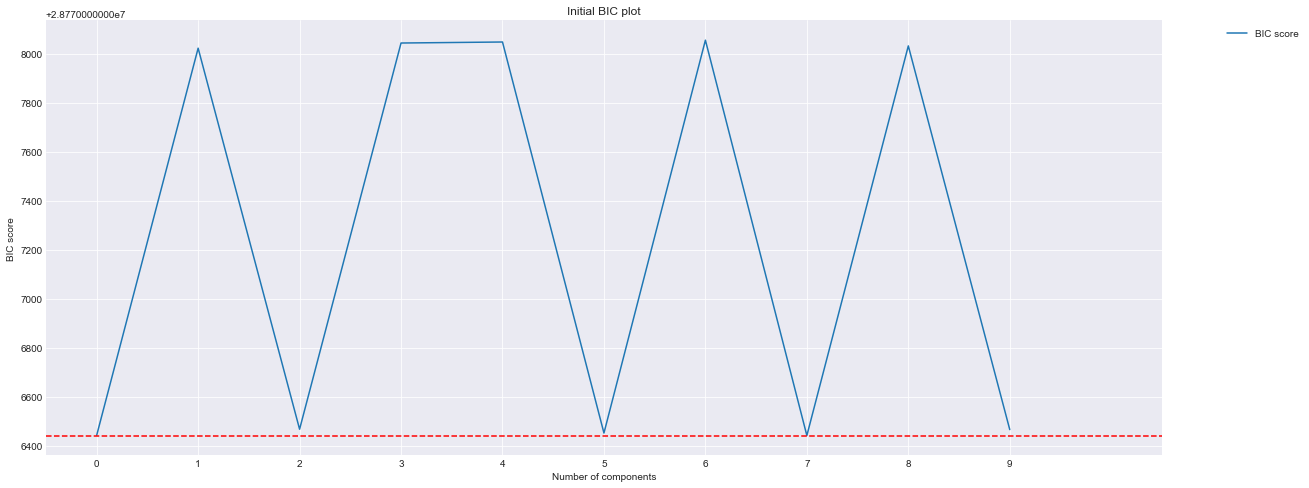

Component number with minimum BIC score: 2 with a score of 28776441.366040032 from run 7.


In [25]:
#BIC curve plotting cell
bicPlot(bicRaw, 0, firstBicLoopControl, 1, "Initial BIC plot", "BIC score", 1)
plt.axhline(bicMin, color = "Red", ls="--")
plt.show()
print("Component number with minimum BIC score: "+str(componentNo)+" with a score of "+str(bicMin)+" from run "+str(GMMRunId)+".")

<br>

### Assigning class labels to each profile using the best GMM
Implementation of classification.

In [26]:
#Classification and classification probability cell
labels = bestGMModel.predict(sampleDataScaledPCA) #assignment of class labels from best GMM
posteriorProbs = bestGMModel.predict_proba(sampleDataScaledPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)
classUncertainty = 2 - 2*maxPosteriorProbs
print("Labels, posterior probabilities and class uncertainties identified.")

Labels, posterior probabilities and class uncertainties identified.


In [27]:
#Initial class labels to sampleDF table cell
try:
    sampleDF = sampleDF.drop(columns=["label", "max posterior prob", "classUncertainty"]) #removes any previous labels or probabilities
except:
    pass
sampleDF.insert(3, "label", labels, True)
sampleDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
sampleDF.insert(5, "classUncertainty", classUncertainty, True)
print("Labels identified for model ("+str(componentNo)+" components) and added to sampleDF with associated probability.")

Labels identified for model (2 components) and added to sampleDF with associated probability.


<br>

### Calculating properties of profiles based on class assignment

In [28]:
#Class Mean Calculation Cell
sampleDFGrouped = sampleDF.groupby("label") #group profiles according to label
sampleDFMeans = sampleDFGrouped.mean() #calculate mean of all profiles in each class
print("Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).")

Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).


<br>

### Sort the labels based on mean near-surface temperatures

In [29]:
#Sorted Dictionary creation cell
surfaceMeans = sampleDFMeans[surfaceTemp].to_numpy() #Takes first temperature data column
surfaceMeansOrder = np.argsort(surfaceMeans)
di = dict(zip(surfaceMeansOrder, range(0, componentNo)))
print("Surface temperature means taken and sorted. Label dictionary created and stored in di.")

Surface temperature means taken and sorted. Label dictionary created and stored in di.


In [30]:
#Sorted label column to tables cell
try: #Removing labelSorted column from tables
    sampleMetaDF = sampleMetaDF.drop(columns = "labelSorted")
except:
    pass
try:
    sampleDF = sampleDF.drop(columns = "labelSorted")
except:
    pass

#Adding sorted label information to sampleMetaDF and sampleDF
sampleMetaDF.insert(3, "labelSorted", sampleDF["label"].map(di))
sampleDF.insert(5, "labelSorted", sampleDF["label"].map(di))
print("Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.")

Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.


In [31]:
#Probability and uncertainty adition to sampleMetaDF (cell)
try:
    sampleMetaDF = sampleMetaDF.drop(columns = ["max posterior prob", "classUncertainty"])
except:
    pass

sampleMetaDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
sampleMetaDF.insert(5, "classUncertainty", classUncertainty, True)
sampleMetaDF.head()

,lat,lon,time,labelSorted,max posterior prob,classUncertainty
0,-65.703316,73.5,1980-01-01,0,1.0,2.965486e-10
1,-65.288567,73.5,1980-01-01,0,1.0,5.714185e-11
2,-63.562469,73.5,1980-01-01,0,1.0,1.422853e-10
3,-60.270821,73.5,1980-01-01,0,1.0,1.603589e-08
4,-59.771149,73.5,1980-01-01,0,1.0,9.994003e-09


<br>

### Use pandas to calculate the properties of the profiles by sorted label

In [32]:
#Class temperature means and stds cell
sampleDFSortGrouped = sampleDF.groupby("labelSorted")
sampleDFSortMeans = sampleDFSortGrouped.mean()
sampleDFSortStds = sampleDFSortGrouped.std()
profileCount = sampleDFSortGrouped[sampleDF.columns[0]].count().to_numpy()
print("sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).")
print("Number of samples in each group calculated and stored in profileCount.")

sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).
Number of samples in each group calculated and stored in profileCount.


<br>

### Confirmation of sorting
The means printed below should be ordered, going from coldest to warmest.

In [33]:
#Temperature display cell
print(sampleDFSortMeans[sampleDataDF.columns[0]])

labelSorted
0     0.394439
1    12.374220
Name: 0.5057600140571594, dtype: float32


<br>

### Plotting the means and standard deviations of the classes by profile

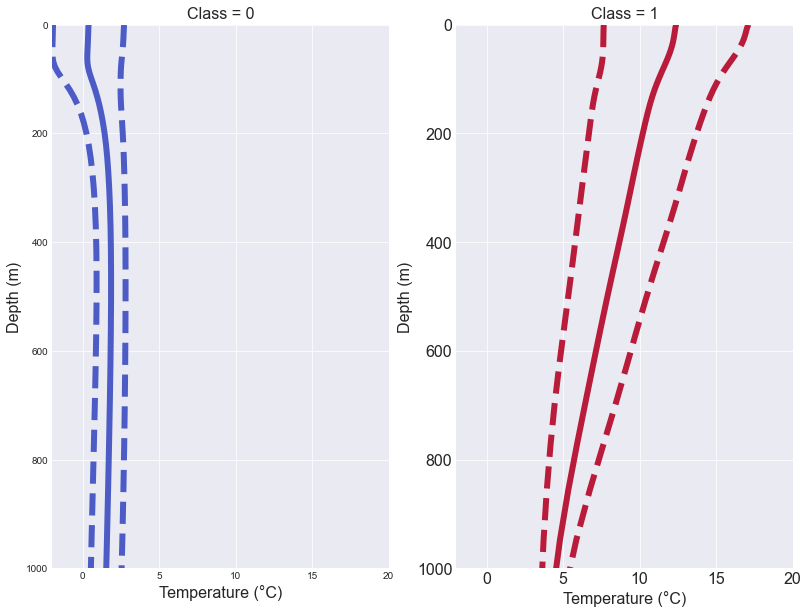

In [34]:
#Plotting mean and std profiles cell
tempGroupProfile(sampleDFSortMeans, sampleDFSortStds, 1)
plt.show()

<br>

### Plotting location and cluster

In [35]:
#Surface Temperature Plotting Cell
if False:
    plt.figure(1, figsize=(20,20))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(sampleDF["lon"], sampleDF["lat"], transform=ccrs.PlateCarree(), c =  sampleDF[surfaceTempName], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Surface Temperature of Samples")
    plt.show()

In [36]:
#locationPlotGroupDFLab(sampleDF, "Location plot of grouping", (25,25), 1)

In [37]:
#locationPlotGroupDFMonthly(sampleDF, "Monthly summaries for training data set", 1)
print("Classifications, grouped by month.")

Classifications, grouped by month.


In [38]:
#locationPlotUncertaintyDFMonthly(sampleDF, "Monthly uncertainty", 1)
print("Uncertainty in classifications, grouped by month.")

Uncertainty in classifications, grouped by month.


<br>

### Exporting Meta Data

In [39]:
#Meta data export cell
exportName = modelName + "_Meta"
sampleMetaDF.to_csv(exportName) #Exporting meta data
exportName = modelName + "_Mask"
np.save(exportName, mask)
print("Meta data and mask exported to "+modelName+" _Meta.csv and _Mask.npy respectively")

Meta data and mask exported to GMM_UK_2Class_R3_v2 _Meta.csv and _Mask.npy respectively


In [40]:
#Meta data reload cell
importName = modelName + "_Meta"
sampleMetaReload = pd.read_csv(importName)
print("Meta data reloaded from "+ importName +". "+str(len(sampleMetaReload))+" samples identified.")
sampleMetaReload.head()

Meta data reloaded from GMM_UK_2Class_R3_v2_Meta. 2716200 samples identified.


,Unnamed: 0,lat,lon,time,labelSorted,max posterior prob,classUncertainty
0,0,-65.703316,73.5,1980-01-01,0,1.0,2.965486e-10
1,1,-65.288570,73.5,1980-01-01,0,1.0,5.714185e-11
2,2,-63.562470,73.5,1980-01-01,0,1.0,1.422853e-10
3,3,-60.270820,73.5,1980-01-01,0,1.0,1.603589e-08
4,4,-59.771150,73.5,1980-01-01,0,1.0,9.994003e-09


<br>

### Exporting Scaler

In [41]:
#Exporting scaler cell
exportName = modelName + "_Scaler"
dump(scalerUK, exportName, compress=True) #Saves
print("Scaler exported to "+ exportName +".")

Scaler exported to GMM_UK_2Class_R3_v2_Scaler.


<br>

### Exporting PCA

In [42]:
#Exporting PCA cell
exportName = modelName + "_PCA.pkl"
pk.dump(pca, open(exportName, "wb"))
print("PCA exported to "+ exportName + ".")

PCA exported to GMM_UK_2Class_R3_v2_PCA.pkl.


In [43]:
#Reloading PCA cell
importName = modelName + "_PCA.pkl"
pca_reload = pk.load(open(importName, "rb"))

totalVarianceExplainedOg = np.sum(pca.explained_variance_ratio_)
pca_reload.fit(sampleDataScaled)
totalVarianceExplainedRe = np.sum(pca_reload.explained_variance_ratio_)
print("PCA reloaded. Original total variance was: "+str(totalVarianceExplainedOg)+". Reloaded total variance was: "+str(totalVarianceExplainedRe)+".")

PCA reloaded. Original total variance was: 0.9908888941743108. Reloaded total variance was: 0.9908889061184015.


<br>

### Single Point investigation

In [44]:
#Initial anomalous data point df creation cell
labelAnomDF = sampleDF[np.logical_or(np.logical_and(sampleDF["lat"]<-60, sampleDF["labelSorted"]==1), np.logical_and(sampleDF["lat"]>-45, sampleDF["labelSorted"]==0))]
print("Class 0 above -45 and Class 1 below -60 lat. Stored in labelAnomDF. "+str(len(labelAnomDF))+" anomalous points detected.")

Class 0 above -45 and Class 1 below -60 lat. Stored in labelAnomDF. 691 anomalous points detected.


In [45]:
#High confidence anomalous data point df creation cell
labelAnomConDF = labelAnomDF[labelAnomDF["classUncertainty"]<0.25]
print("High Classification Confidence DF of labelAnomDF (<0.25). "+str(len(labelAnomConDF))+" anomalous points detected.")

High Classification Confidence DF of labelAnomDF (<0.25). 92 anomalous points detected.


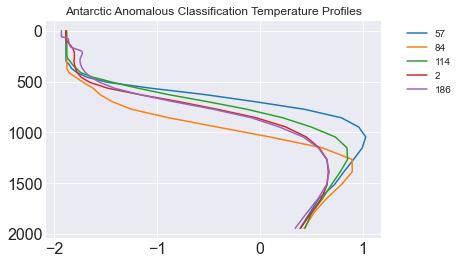

In [46]:
antarcticAnomDF = labelAnomDF[np.logical_and(labelAnomDF["label"]==1, labelAnomDF["lat"]<-70)]
#antarcticAnomDF
for i in range(5):
    x = np.random.randint(len(antarcticAnomDF))
    tempProfile = np.array(antarcticAnomDF.iloc[x, 7:])
    tempPointPlot(tempProfile, x, "Antarctic Anomalous Classification Temperature Profiles", 1)
    
    #tempProfileScaled = scalerUK.transform(tempProfile)
    #tempPointPlot(tempProfileScaled, x, "Antarctic Anomalous Classification Temperature Profiles Scaled", 2)
plt.show()

In [48]:
x = np.load("GMM_UK_2Class_R1_Mask.npy")
y = np.load("GMM_UK_2Class_R3_v2_Mask.npy")
z = (x == y)
for i in z:
    if i:
        continue
    else:
        print("False")

### End of Notepad